**Avatars IDs**

- Mens US ASTM Sz M/40, MALE ID: "b4ec391f-4a63-41ad-8efd-f3e45c75bb28"

- Womens US ASTM Sz M/6, FEMALE ID: "ad80d4fd-cf03-4337-b42a-8df04ea07bcc"

# *Compute new positions of the garment*

In [21]:
import json
import math

#IMPORT SCENE
rute = 'store_state_transformed.json'

with open(rute) as archivo:
    data = json.load(archivo)

# Avatar & Pieces geometry data
avatar = data["avatar"]
pieces = data["pieces"]

#print("Avatar", avatar)

all_pieces_indices = []
all_pieces_position3d = []
all_pieces_position2d = []


# Rotation
def rotate_point(x, y, theta):
    x_rotated = x * math.cos(theta) - y * math.sin(theta)
    y_rotated = x * math.sin(theta) + y * math.cos(theta)
    return x_rotated, y_rotated

for piece in data['pieces']:
    indices = piece['components']['garmentPiece']['geometry']['indices']
    position3D = piece['components']['garmentPiece']['geometry']['position3D']
    position2D = piece['components']['garmentPiece']['geometry']['position2D']    
    rotation = piece['components']['transform2D']['rotation']
    translation = piece['components']['transform2D']['translation']
    
    all_pieces_indices.extend(indices)
    all_pieces_position3d.extend(position3D)

    #GET PIECE 2D COORDINATES ROTATED & TRANSLATED
    for i in range(0, len(position2D), 2):

        x = position2D[i]
        y = position2D[i + 1]
        
        # Rotation
        x_rotated, y_rotated = rotate_point(x, y, rotation)

        # Translation
        x_translated = x_rotated + translation['x']
        y_translated = y_rotated + translation['y']
        
        # Update 2d coordinates
        position2D[i] = x_translated
        position2D[i + 1] = y_translated
    all_pieces_position2d.extend(position2D)

transformed_poms = []

# ALL POMS TRANSFORMED POSITIONS
for pom in data["poms"]:

    garment_piece_id = pom["garmentPieceId"]

    # TRANSFORM associated with pom
    for piece in data['pieces']:
        if piece['_id'] == garment_piece_id:
            rotation = piece['components']['transform2D']['rotation']
            translation = piece['components']['transform2D']['translation']
            break

    # POM COORDS
    pom_coords = [(point["position"]["x"], point["position"]["y"]) for point in pom["position"]["_path"]]
    transformed_pom_coords = []
    for x, y in pom_coords:
        # Rotation
        x_rotated, y_rotated = rotate_point(x, y, rotation)
        # Translation
        x_translated = x_rotated + translation['x']
        y_translated = y_rotated + translation['y']
        transformed_pom_coords.append((x_translated, y_translated))
    transformed_poms.append(transformed_pom_coords)
        

print("Pieces", len(all_pieces_position3d)/3)
print("Pieces", len(all_pieces_position2d)/2)


Pieces 8895.0
Pieces 8895.0


In [22]:
import numpy as np

#Convert to numpy arrays & matrix
avatar_indices = np.array(avatar["indices"])
avatar_positions = np.array(avatar["positions"]).reshape(-1, 3)  # 3 colum matrix 

pieces_indices = np.array(all_pieces_indices)
pieces_positions = np.array(all_pieces_position3d).reshape(-1, 3)  # 3 colum matrix 
pieces_positions2d = np.array(all_pieces_position2d)


In [23]:
# Compute min distances garment-avatar
min_distances = np.zeros(len(pieces_positions))
ac = np.zeros(len(pieces_positions), dtype=int) # Avatar Correspondences

# For all vertex in the garment
for i, pos_prenda in enumerate(pieces_positions):
    dist_vertex = np.linalg.norm(pos_prenda - avatar_positions, axis=1)
    # Find nearest avatar index and compute min distance
    nearest_indice_vertex = np.argmin(dist_vertex)
    min_dist = dist_vertex[nearest_indice_vertex]
    #print(distancias_vertice[indice_vertice_cercano])

    # Save min distances and avatar index correspondences
    min_distances[i] = min_dist
    ac[i] = nearest_indice_vertex



In [24]:
# Offset between garment vertex and its nearest avatar vertex
offsets = np.zeros_like(pieces_positions)

for i, indice_avatar in enumerate(ac):
    offset = np.array(pieces_positions[i])- np.array(avatar_positions[indice_avatar])  
    offsets[i]=offset

#print(offsets)



New Avatar

In [25]:
#IMPORT NEW AVATAR
avatars = 'avatars.json'

with open(avatars) as file:
    avatars_data = json.load(file)
new_avatar = avatars_data["male"]

new_avatar_positions= np.array(new_avatar["positions"]).reshape(-1, 3)  # 3d colum matrix


In [26]:
#Compute new pieces positions with the offset computed and its nearest avatar index from the new avatar (Avatars in seddi have the same mesh)
new_pieces_positions = np.zeros_like(pieces_positions)

for i, indice_avatar in enumerate(ac):
    new_pieces_positions[i] = np.array(new_avatar_positions[indice_avatar]) + np.array(offsets[i])


#print(new_pieces_positions)


In [27]:
#Export SCENE TO JSON for AUTHOR

import json
#IMPORT SCENE
rute = 'store_state_transformed.json'

with open(rute) as archivo:
    data = json.load(archivo)


pieces = data["pieces"]
new_list_positions = new_pieces_positions.reshape(-1).tolist()

for piece in data['pieces']:
    indices = piece['components']['garmentPiece']['geometry']['indices']
    positions = piece['components']['garmentPiece']['geometry']['position3D']

    # Len atucal piece
    length_piece = len(positions)
    # Get new positions actual piece
    new_positions = new_list_positions[:length_piece]

    # Remplace for new positions
    piece['components']['garmentPiece']['geometry']['position3D'] = new_positions
    
    # Update new_pieces_positions to next piece
    new_list_positions = new_list_positions[length_piece:]

with open("output.json", "w") as outfile: 
      json.dump(data, outfile)
print("Datos exportados a 'output.json'")

Datos exportados a 'output.json'


DEFORMATION METRICS FOR 2D PATTERN

POM: C0: -0.6383143706512768 0.9623580600507352 C1: -0.06360874881979689 0.9623528064053936


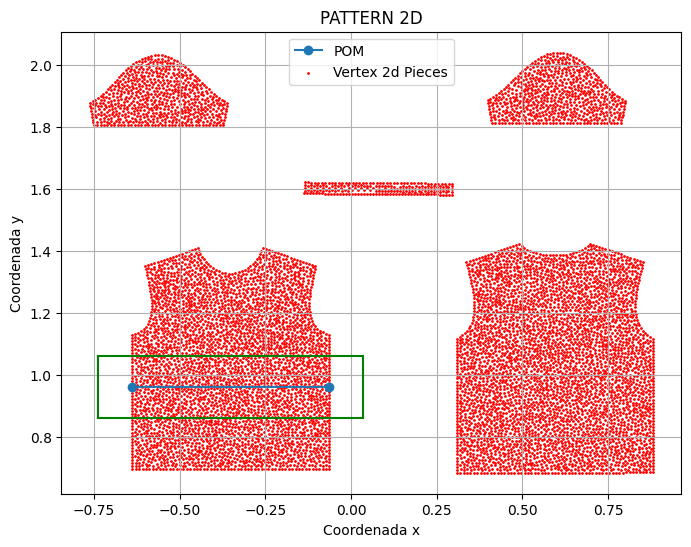

In [28]:
#Vertex defined by POM POINTS
import matplotlib.pyplot as plt


#GET POMS COORDINATES
class Coordinates:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y

poms = data["poms"]
#print(transformed_poms[0][0][0])
pom_C0=Coordinates(transformed_poms[0][0][0],transformed_poms[0][0][1])
pom_C1=Coordinates(transformed_poms[0][1][0],transformed_poms[0][1][1])


POM = transformed_poms
print("POM:","C0:",pom_C0.x,pom_C0.y,"C1:",pom_C1.x,pom_C1.y)

#print(pieces_positions2d)
pieces_2d = []
for i in range(0, len(pieces_positions2d), 2):
    x = pieces_positions2d[i]
    y = pieces_positions2d[i + 1]
    pieces_2d.append(Coordinates(x, y))


# PLOT
plt.figure(figsize=(8, 6))
margin = 0.1  # margin
min_x = np.min(pom_C0.x) - margin
max_x = np.max(pom_C1.x) + margin
min_y = np.min(pom_C0.y) - margin
max_y = np.max(pom_C1.y) + margin

# Bounding box
plt.plot([min_x, max_x], [min_y, min_y], color='green') # Inferior Line
plt.plot([min_x, max_x], [max_y, max_y], color='green') # Superior Line
plt.plot([min_x, min_x], [min_y, max_y], color='green') # Left Line
plt.plot([max_x, max_x], [min_y, max_y], color='green') # Right Line

plt.plot([pom_C0.x, pom_C1.x], [pom_C0.y, pom_C1.y], marker='o', label='POM')


plt.scatter([position.x for position in pieces_2d], 
            [position.y for position in pieces_2d], 
            color='red',s=1, label='Vertex 2d Pieces')


plt.xlabel('Coordenada x')
plt.ylabel('Coordenada y')
plt.title('PATTERN 2D')
plt.legend()

plt.grid(True)
plt.show()




Diferencia en longitudes de aristas entre los dos avatares:


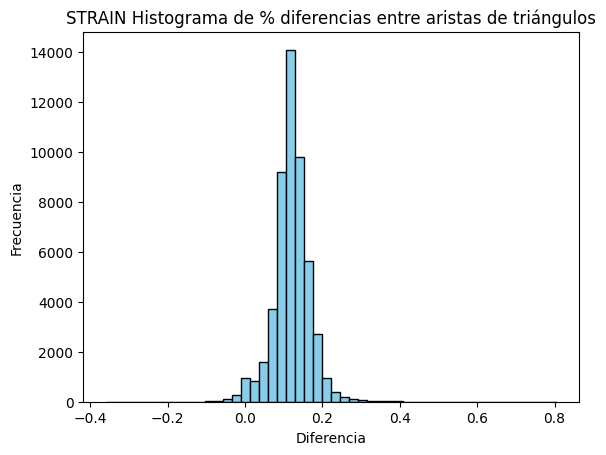

In [40]:
#COMPUTE DEFORMATION METRIC 3D: EDGE LENGTH

def compute_edge_lengths(points, indices):
    edge_lengths = []
    for i in range(0, len(indices), 3):
        # Obtener los índices de los puntos que forman el triángulo
        p1_index, p2_index, p3_index = indices[i], indices[i+1], indices[i+2]

        # Obtener las posiciones 3D de los puntos del triángulo
        p1 = points[p1_index]
        p2 = points[p2_index]
        p3 = points[p3_index]

        # Calcular la longitud de cada arista usando np.linalg.norm
        edge_ab = np.linalg.norm(p2 - p1)
        edge_bc = np.linalg.norm(p3 - p2)
        edge_ca = np.linalg.norm(p1 - p3)

        edge_lengths.append(edge_ab)
        edge_lengths.append(edge_bc)
        edge_lengths.append(edge_ca)

    return edge_lengths

def compute_edge_difference(avatar1_lengths, avatar2_lengths):
    if len(avatar1_lengths) != len(avatar2_lengths):
        raise ValueError("AVATARS NEED SAME NUMBER OF EDGES.")
    
    differences = np.abs(np.array(avatar1_lengths) - np.array(avatar2_lengths))
    return differences
    
def compute_edge_strain(edge_length, original_edge_length):

    return edge_length / original_edge_length - 1

def compute_total_strain(avatar1_lengths, avatar2_lengths):
    total_strain = []
    for edge_length, original_length in zip(avatar2_lengths, avatar1_lengths):
        strain = compute_edge_strain(edge_length, original_length)
        total_strain.append(strain)
    
    return np.array(total_strain)

avatar1_3dpoints = pieces_positions
avatar2_3dpoints = new_pieces_positions

# COMPUTE EDGE LENGTHS Avatar 1 & Avatar 2
avatar1_edge_lengths = compute_edge_lengths(avatar1_3dpoints,pieces_indices)
avatar2_edge_lengths = compute_edge_lengths(avatar2_3dpoints,pieces_indices)

# Compute the difference in edge lengths between the two avatars
diff_edges = compute_edge_difference(avatar1_edge_lengths, avatar2_edge_lengths)

target_strain = compute_total_strain(np.array(avatar1_edge_lengths), np.array(avatar2_edge_lengths)).flatten()

print("Diferencia en longitudes de aristas entre los dos avatares:")

# Crear el histograma
plt.hist(target_strain, bins=50, color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('Diferencia')
plt.ylabel('Frecuencia')
plt.title('STRAIN Histograma de % diferencias entre aristas de triángulos')

# Mostrar el histograma
plt.show()


In [41]:
#OPTIMIZACION



import torch


# Estos serían los controles de los poms que queremos optimizar, en este caso sólo hay 1

pom = torch.tensor([2.0])  ##ANCHURA

# Esta función es la que te calcula los puntos de control de la boundary en función de los poms.

# En este caso es un simple producto para sacar los dos puntos de control, en tu caso será algo

# más complejo, equivalente a lo que tengáis montado en javascript

def compute_boundary_control_points(pom):

    c0 = pom * -0.5

    c1 = pom * 0.5
    
    return c0, c1


# Éstas son las coordenadas paramétricas de los vértices en base a los puntos de control, que tendrás que calcular en el 2D

# original, y aquí las usamos para calcular las nuevas posiciones 2D cuando se deforman los puntos de control. Yo las defino a mano

# para que encajen más o menos con el dibujo

v0_alpha = 0.25

v1_alpha = 0.5


# Cálculo de los vértices en base a los puntos de control

def compute_vertices(c0, c1, v0_alpha, v1_alpha):

    v0 = c0 * (1 - v0_alpha) + c1 * (v0_alpha)

    v1 = c0 * (1 - v1_alpha) + c1 * (v1_alpha)


    return v0, v1


# Cálculo de la longitud de la arista. En mi caso que es 1d es sacar el valor absoluto de una resta,

# en tu caso serán normas de vectores

def compute_edge_length(v0, v1):

    return (v0 - v1).abs()


# longitud original del edge, hay que sacarlo de la configuración inicial 2D, yo voy a sacarlo con los valores

# iniciales de este mismo script

c0, c1 = compute_boundary_control_points(pom)

v0, v1 = compute_vertices(c0, c1, v0_alpha, v1_alpha)

original_edge_length = compute_edge_length(v0, v1)

print(c0,c1)
print(v0, v1 )

# función que mide el strain de la arista, cuánto se ha estirado/comprimido en

# porcentaje (0 = no hay cambio, 1 = 100% de estirado, 0.5 = 50% de compresion, etc)

def compute_strain(edge_length, original_edge_length):

    return edge_length / original_edge_length - 1


# el strain objetivo, que sacamos como el strain que ha sufrido la arista en el 3D al llevarla al nuevo cuerpo

# aquí me invento que el 3D se ha estirado un 100%, y es lo que queremos conseguir con la optimización para el 2D.

target_strain = 1


# Función de coste a optimizar, que es el cuadrado de la diferencia entre el strain actual y el objetivo. En tu caso será

# una suma de los cuadrados de las diferencias de cada arista

def cost_function(strain, target_strain):

    return (strain - target_strain) ** 2


# Vuelvo a definir el pom inicial, pero ahora le digo que quiero que calcule gradientes, para poder hacer la optimización

pom = torch.tensor([2.0], requires_grad=True)


# Se define el optimizador

optimizer = torch.optim.Adam([pom], 1e-2)


# Vamos a hacer 500 pasos de optimización. En el caso real, habría que hacer iteraciones hasta llegar a convergencia, por ejemplo,

# hasta que los poms apenas cambien después de varias iteraciones.

for i in range(500):

    # Se reinician los gradientes

    optimizer.zero_grad()

    # Se calcula la función de coste desde el POM hasta la loss

    c0, c1 = compute_boundary_control_points(pom)

    v0, v1 = compute_vertices(c0, c1, v0_alpha, v1_alpha)

    e_length = compute_edge_length(v0, v1)

    strain = compute_strain(e_length, original_edge_length)

    loss = cost_function(strain, target_strain)


    print(f"Step # {i}, loss: {loss.item()}, pom: {pom.item()}")

    print(f"  c0: {c0.item()}, c1: {c1.item()}")

    print(f"  v0: {v0.item()}, v1: {v1.item()}")

    print(f"  e_l: {e_length.item()}")


    # Se calculan los gradientes y se propagan hacia atrás

    loss.backward()

    # Se da un paso de optimización

    optimizer.step()

tensor([-1.]) tensor([1.])
tensor([-0.5000]) tensor([0.])
Step # 0, loss: 1.0, pom: 2.0
  c0: -1.0, c1: 1.0
  v0: -0.5, v1: 0.0
  e_l: 0.5
Step # 1, loss: 0.9900252223014832, pom: 2.009999990463257
  c0: -1.0049999952316284, c1: 1.0049999952316284
  v0: -0.5024999380111694, v1: 0.0
  e_l: 0.5024999380111694
Step # 2, loss: 0.9801014065742493, pom: 2.019998550415039
  c0: -1.0099992752075195, c1: 1.0099992752075195
  v0: -0.5049996376037598, v1: 0.0
  e_l: 0.5049996376037598
Step # 3, loss: 0.970229983329773, pom: 2.0299949645996094
  c0: -1.0149974822998047, c1: 1.0149974822998047
  v0: -0.5074987411499023, v1: 0.0
  e_l: 0.5074987411499023
Step # 4, loss: 0.9604117274284363, pom: 2.0399882793426514
  c0: -1.0199941396713257, c1: 1.0199941396713257
  v0: -0.5099970102310181, v1: 0.0
  e_l: 0.5099970102310181
Step # 5, loss: 0.9506466388702393, pom: 2.0499775409698486
  c0: -1.0249887704849243, c1: 1.0249887704849243
  v0: -0.5124944448471069, v1: 0.0
  e_l: 0.5124944448471069
Step # 6,